<a href="https://colab.research.google.com/github/sv-Tjipto/COMP4702_V2/blob/main/prac6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A gentle and intuitive introduction to Neural Networks using PyTorch
The goal of this prac is to familiarise you with the components of a neural network (NN). A neural network is a uni-directional graph whereby the function $\sigma_l(W_lx+b_l)$ where $\sigma$, $W$, $b$ are the activation function, weight matrix, and bias vector respectively for each layer, $l$, and $x$ is the output of layer $l-1$. Theoretically, neural networks are so good because they can generalise to any function $f(x)$

Whilst NNs are a relatively simple concept, implementing them can be tricky to the uninitiated. Here we will try to break them down into simpler components so that you can begin to understand them.

Initially, the NN model can be seen to be made up of these core components:
* the number of layers and the number of neurons they contain,
* the activation function,
* and the weight and bias initialisers

Finally, we need to give:
* a loss function,
* and an optimiser

Today we will implement the simplest NN model, a multi-layer perceptron (MLP), which comprises of the input layer, at least one hidden fully connected layer, and the output layer.

We are using PyTorch due to its growing popularity and ease of use. Tensorflow provides an equivalent API that is similarly easy to use with the addition of Keras. At the end of this sheet there will be some follow up tasks for you to complete.

##Set up
Go to Runtime -> click Change runtime type -> Change Hardware accelerator to GPU or TPU if you're feeling spice (not sure if usefull :D)
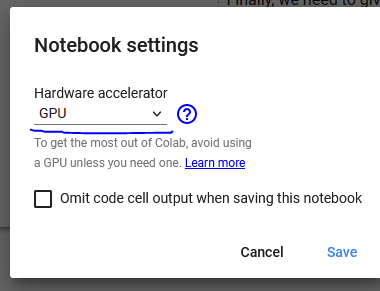

### Install torch, matplotlib, and seaborn
(It's probably already installed... it was for me.)

In [ ]:
!pip install torch matplotlib seaborn numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Check the version and if we have a GPU available
Should look something like:

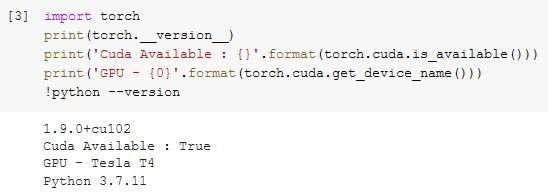

In [ ]:
import torch
print(torch.__version__)
print('Cuda Available : {}'.format(torch.cuda.is_available()))
print('GPU - {0}'.format(torch.cuda.get_device_name()))
!python --version

1.13.1+cu116
Cuda Available : True
GPU - Tesla T4
Python 3.9.16


## Define a model
The components we need to define a model (as stated above) are:
* the number of layers and the number of neurons they contain,
* the activation function,
* and the weight and bias initialisers

We can do this by creating a [sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model that comprises of [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) computations followed by a [non-linear](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) activation function.

### Model Configuration
The first model we will make will have one hidden layer and will look something like this:

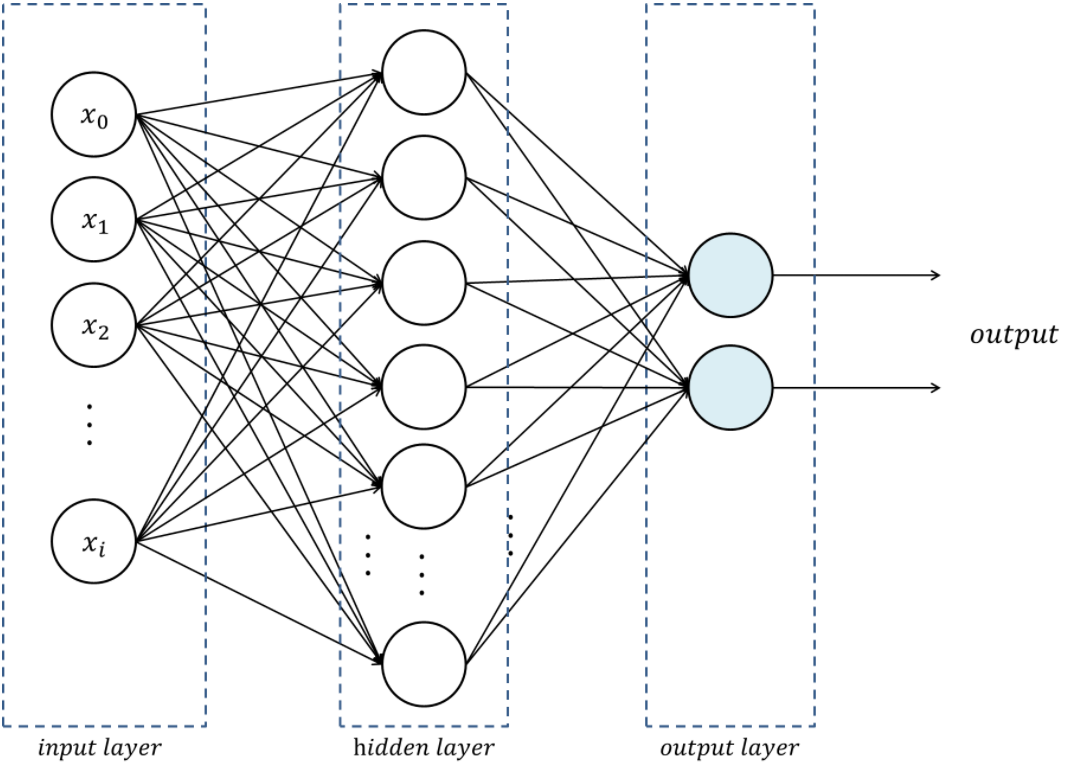

Image courtesy of https://www.cc.gatech.edu/~san37/post/dlhc-fnn/


We can extend the number of hidden layers ad-infinitum relatively simply. The weights are what make up the links (the arrows in the above picture) and the biases are added to these at each node. So the weight matrix has a shape of (neurons in previous layer, neurons in this layer) and the bias vector has a shape of (neurons in this layer,1). The input layer will be the same dimension as the data we are trying to characterise (if it is >1D we flatten it to 1D.). The output layer will be the number of classes in our dataset or the number of values we are trying to regress.

### Activation functions

These could be considered the special sauce of the NN as they characterise the shape of the decision boundary. Currently, the most popular activation functions are peicewise linear functions like the ReLU:

Text(0, 0.5, 'ReLU(x)')

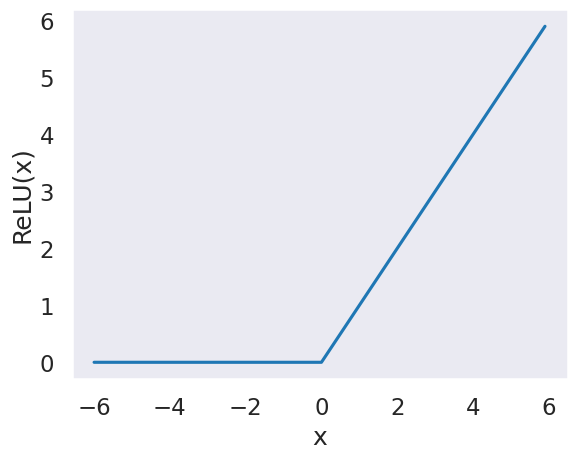

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#Set the plot style
sns.set_context('talk')
sns.set_style('dark')
relu = torch.nn.ReLU()
input = torch.arange(-6,6,step=0.1)
output = relu(input)
sns.lineplot(x=input,y=output)
plt.xlabel('x')
plt.ylabel('ReLU(x)')

A more old fashioned approach was to use tanh or the sigmoid function. This was before the emergence of powerful NNs and their rise to popularity in the past decade.

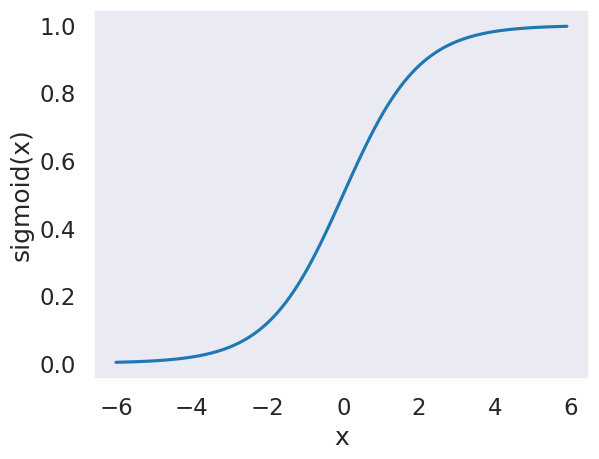

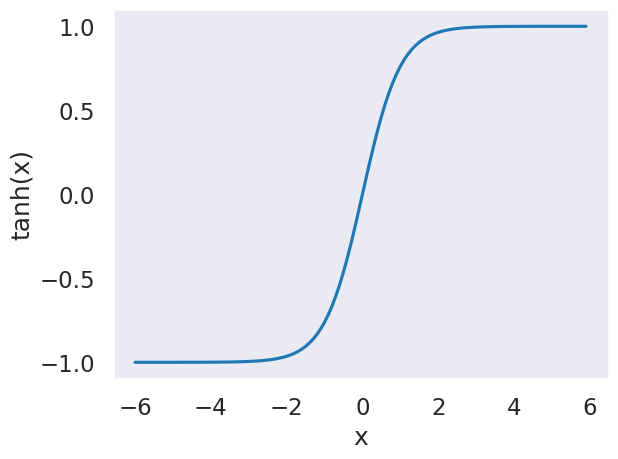

In [ ]:
output_sigmoid = torch.nn.Sigmoid()(input)
sns.lineplot(x=input,y=output_sigmoid)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.show()
output_tanh = torch.nn.Tanh()(input)
sns.lineplot(x=input,y=output_tanh)
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.show()


These functions have problems with vanishing gradients when the functions saturate (we compute gradients to optimise the $W$ matrices and $b$ vectors) but at the same time the ReLU function can suffer from 0 gradients too.

### Weight initialisation
We have a few strategies to initialise weights and biases but are often overlooked because some of the adaptive optimisation techniques apparently reduce the importance of weight initialisation. Common methods include Glorot and  Xavier which you can check out in your own time. We will simply allow for the default behaviour given by torch's [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer

### Model Creation
We will define a function that specifies dimensions in, dimensions out, and a list of integers containing each hidden layers size. We can use torch's inbuilt [sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model for simplicity.

In [ ]:
from typing import List #just to help readability
def create_sequential_model(dim_in:int, dim_out:int, hidden_layer_sizes:List[int]):
  print(dim_in)
  hiddens = [dim_in, *hidden_layer_sizes]
  torch_layers = []
  #Create a linear layer and feed it through a ReLU
  for i in range(len(hiddens)-1):
    torch_layers.append(torch.nn.Linear(hiddens[i], hiddens[i+1]))
    torch_layers.append(torch.nn.ReLU())
  torch_layers.append(torch.nn.Linear(hiddens[-1], dim_out)) #create the output layer
  return torch.nn.Sequential(*torch_layers)

### Loss function

The loss function we choose depends on the problem at hand. We could use cross-entropy with logits for classification, and we could use something like MSE for regression. These are the loss functions that we will start with in this prac.  

There are many loss functions that we can use and as always no free lunch theorem holds. Some problems and models will perform better with certain loss functions.

**Important:** When evaluating your model it is important to look at both accuracy and loss, as loss can sometimes be misleading.

### Optimisers
The most popular optimisers that are currently used with NNs are a family of stochastic gradient descent (SGD) optimisers. The stochastic part of SGD primarily means that we sample random batchs of size N from our dataset. This reduces bias but increases variance. This method has is necessary when dealing with large datasets as most computers do not have enough memory to load millions or billions of images at once.  

SGD optimisers that we can use in torch include standard SGD, SGD with momentum, and fancier SGD variants with adaptive learning rates like ADAM, ADAGRAD, RMSPROP etc.

We can implement a simple SGD function ourselves.

The first thing we need to do to choose the loss function and optimiser is to pick a dataset



### Dataset
We'll start with classification and use CIFAR10 because it's slightly less overdone than MNIST and it might be a little harder to get 90%+ accuracy with default settings... maybe.

In [ ]:
import torchvision

CIFAR10_train = torchvision.datasets.CIFAR10('CIFAR10_data',download=True,train=True, transform=True)
CIFAR10_validation = torchvision.datasets.CIFAR10('CIFAR10_data',download=True,train=False, transform=True)
print(CIFAR10_train.data.shape)
print(len(CIFAR10_train.classes))
training_data = (CIFAR10_train.data.reshape((-1,32*32*3))/255.0).astype(np.float32) # flatten the dataset and normalise
training_labels = np.asarray(CIFAR10_train.targets)
validation_data = (CIFAR10_validation.data.reshape((-1,32*32*3))/255.0).astype(np.float32) # flatten the dataset and normalise
validation_labels = np.asarray(CIFAR10_validation.targets)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data
Files already downloaded and verified
(50000, 32, 32, 3)
10


We can see that the image is 32x32x3, this means that it is a dataset of 32x32 pixel RGB images. We will need to flatten to (50000,32x32x3) this for our model. It also has 10 classes so our model will have to have 10 outputs. We will start with one hiddel layer with one hundred neurons.

In [ ]:
model = create_sequential_model(32*32*3,10, [100,100])

3072


Because this is a classification problem we can use [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [sgd](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=sgd)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
learning_rate = 1e-3 #starting learning rate that we can tweak to increase performance
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate) #model.parameters gives the weight matrices and biases to the optimiser (AKA trainable parameters)

### Training
To train our model we need to iterate applying gradient descent to the model w.r.t the loss. Overtime hopefully we will see accuracy increase and loss decrease.

In [ ]:
batch_size = 256 #the number of datapoints per batch that we do
optimisation_steps = int(1e4) #the number of batches that we train on

In [ ]:
import numpy as np

metrics = []
for i in range(optimisation_steps):
  idx = np.random.randint(0, training_data.shape[0], size = batch_size) # random sample of batch_size indices from 0 to the number of datapoints the dataset has
  x = training_data[idx,:] # get the datapoints at the sampled indices
  # flattened_x = torch.from_numpy(x.reshape(batch_size,-1)).as # flatten the datapoints
  y_pred = model(torch.from_numpy(x)) # predict the classes of the datapoints)
  loss = criterion(y_pred,torch.from_numpy(training_labels[idx])) # compute the loss by comparing the predicted labels vs the actual labels
  # zero the gradients held by the optimiser
  optimiser.zero_grad()
  # perform a backward pass to compute the gradients
  loss.backward()
  # update the weights
  optimiser.step()
  if i%100==99:
    if i%1000==999:
      train_pred =  model(torch.from_numpy(training_data))
      val_pred =  model(torch.from_numpy(validation_data))
      train_accuracy = torch.mean((train_pred.argmax(dim=1) == torch.from_numpy(training_labels)).float())
      val_accuracy = torch.mean((val_pred.argmax(dim=1) == torch.from_numpy(validation_labels)).float())
      # print the loss every 100 steps
      metrics.append([i,loss.item(),train_accuracy.numpy(), val_accuracy.numpy()])
    print(f'\rEpoch: {i} Loss:{round(loss.item(),2)}', end='')

Epoch: 9999 Loss:1.67

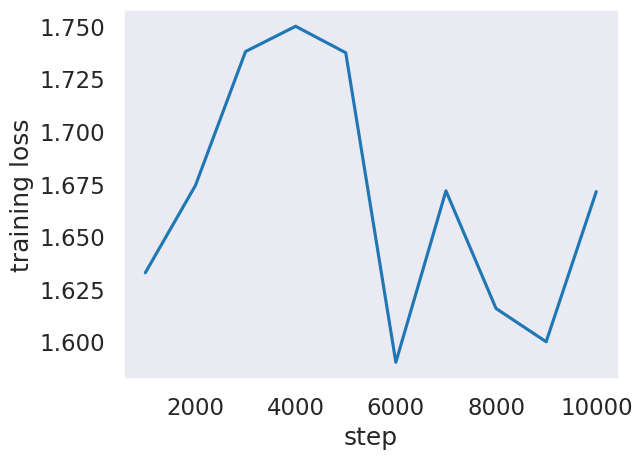

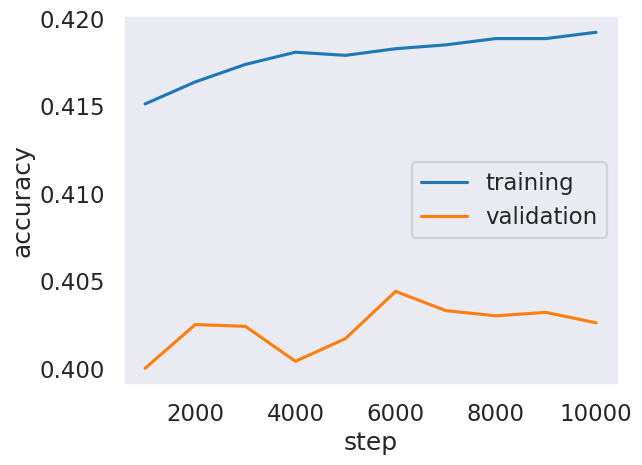

In [ ]:
metrics = np.asarray(metrics)
sns.lineplot(x=metrics[:,0],y=metrics[:,1])
plt.xlabel('step')
plt.ylabel('training loss')
plt.show()
sns.lineplot(x=metrics[:,0],y=metrics[:,2],label='training')
sns.lineplot(x=metrics[:,0],y=metrics[:,3], label='validation')
plt.xlabel('step')
plt.ylabel('accuracy')
plt.show()

## Prac Tasks

1) Find an appropriate data-set to perform regression using an MLP

2) Design an MLP with at least one hidden layer, an adequate batch size and number of steps, and an appropriate loss function and optimiser to perform regression on the dataset you have chosen from point 1.

3) Determine appropriate metrics for you to evaluate the performance of your NN.

4) Run and evaluate your NN multiple times and answer the following questions:
 * What was the variance of your NNs performance? If it was large, why was it large?
 * Why did you choose your performance metric to evaluate your network?
 * Why did you chose the number and size of the layers that you did?
 * Why did you choose your loss function?
 * Why did you choose your optimiser and how did you select its parameters?

Hopefully this prac has demystified NNs a little bit for you. They are slightly magic but hopefully you have built some intuition about how they work and how you can use them on your datasets.